#### Data 620 - Project 2 <br>June 26, 2019<br>Team 2: <ul><li>Anthony Munoz</li> <li>Katie Evers</li> <li>Juliann McEachern</li> <li>Mia Siracusa</li></ul>

<h1 align="center">Network Analysis: 2-Mode Networks</h1>

## Project Overview

In a 2-node dataset, "there are two different types of nodes and links determine relationships between one set of nodes and the other (Tsvetovat & Kouznetsov 96)." We will be examining datasets from a Nowegian study on [Boards and Gender](http://www.boardsandgender.com/data.php). We will examine our 2-Mode Network using a bipartite graph and the island method from our Social Network Analysis text.

#### Python Dependencies 

In [1]:
import pandas as pd, networkx as nx,matplotlib.pyplot as plt, numpy as np, warnings
from networkx.algorithms import bipartite

warnings.filterwarnings('ignore') 

#### Load & Transform Network Data

Data was loaded and merged into a pandas dataframe. Unused columns were dropped and some column were renamed for better understanding of our dataset. A weight was assigned to each row by based on unique organization connections to grouped directors. 

In [2]:
#affiliation of directors to organizational boards
net2m = pd.read_csv('http://www.boardsandgender.com/data/net2m/net2m_2011-07-01.txt', sep=" ", header=None)
net2m.columns=["director", "board"]
#company attributes
comp = pd.read_csv('https://raw.githubusercontent.com/jemceach/620/master/Project-2/companies.csv', header=None)
comp.columns=["id", "org_no","org_name","postcode_city"]; comp=comp.drop(["org_no","postcode_city"], axis=1)
#people attributes
ppl = pd.read_csv('https://raw.githubusercontent.com/jemceach/620/master/Project-2/peoples.csv',encoding = "ISO-8859-1")
ppl['gender'] = ppl['gender'].replace(1, "M").replace(2, "F")
#merge datasets
net2m=net2m.merge(ppl, left_on='director', right_on='id').drop("id",axis=1).merge(comp, left_on='board', right_on='id').drop("id",axis=1)
#add weight using unique counts 
net2m['weight'] = net2m.groupby('director')['board'].nunique()+1; net2m=net2m.replace(np.nan, 1).sort_values("weight")
#preview data
net2m.sort_values("board").head()

,director,board,name,gender,org_name,weight
27,67,3,Allan Boye Hansen,M,ABERDEEN EIENDOMSFOND ASIA ASA,3.0
28,109,3,Anders Talleraas,M,ABERDEEN EIENDOMSFOND ASIA ASA,2.0
81,230,10,Anne Gro Sundby,F,ACTA ASSET MANAGEMENT ASA,1.0
41,106,11,Anders Skjævestad,M,ACTA HOLDING ASA,1.0
70,190,13,Anne-Lise Aspengren,F,AF GRUPPEN ASA,1.0


# Biparthitie Graph

We will be examining the connection between corporate directors and organizational boards. Both factors will treated  as distinct groups. We will retain the gender feature for directors and use this feature when coloring our graph later on. 

#### Build Network

We built our network by looping through our dataset to add 2 sets of bipartite nodes. These nodes were added with the node attribute set to "bipartite". Edges were added only between nodes of opposite bipartite node sets.

In [3]:
## Ref: https://networkx.github.io/documentation/stable/reference/algorithms/bipartite.html

B = nx.Graph()

# add director nodes as bipartite 0
for i in range(len(net2m)): 
    B.add_node(net2m.iloc[i][0],
                name=net2m.iloc[i][2],
                gender=net2m.iloc[i][3],
                bipartite=0)
    
# add borough nodes as bipartite 1
for i in range(len(net2m)): 
    B.add_node(net2m.iloc[i][1],
               org_name=net2m.iloc[i][4],
               bipartite=1)

# connect edges from both bipartite 0 and 1
for i in range(len(net2m)):
    B.add_edge(net2m.iloc[i][0], net2m.iloc[i][1], weight=net2m.iloc[i][5])

# identify top and bottom nodes
top_nodes = {n for n, d in B.nodes(data=True) if d['bipartite']==0}
bottom_nodes = set(B) - top_nodes

# verification
print("Verify graph is_bipartite:",nx.is_bipartite(B))

Verify graph is_bipartite: True


#### Examine Network

The output below highlights some basic features of our network.

In [4]:
print("\nNetwork",nx.info(B))

print("\nList degrees:", B.degree())


Network Name: 
Type: Graph
Number of nodes: 167
Number of edges: 118
Average degree:   1.4132

List degrees: [(3, 3), (220, 2), (219, 2), (214, 1), (211, 3), (210, 1), (198, 1), (190, 1), (187, 1), (217, 2), (181, 2), (175, 2), (158, 2), (154, 1), (149, 1), (366, 1), (147, 2), (227, 1), (144, 1), (143, 2), (225, 1), (133, 2), (230, 3), (239, 2), (350, 1), (349, 1), (341, 1), (335, 1), (334, 1), (333, 1), (315, 1), (310, 1), (309, 1), (302, 1), (300, 2), (298, 1), (276, 3), (268, 1), (373, 2), (266, 3), (264, 3), (248, 1), (243, 1), (132, 2), (368, 1), (118, 1), (79, 3), (73, 3), (28, 1), (22, 1), (72, 1), (52, 1), (61, 1), (54, 3), (136, 3), (27, 2), (120, 1), (104, 2), (37, 1), (85, 1), (115, 1), (34, 1), (114, 2), (5, 1), (177, 1), (106, 5), (15, 1), (103, 1), (7, 1), (97, 2), (361, 2), (95, 1), (58, 2), (277, 2), (18, 1), (313, 3), (24, 1), (338, 2), (11, 2), (360, 1), (280, 2), (235, 1), (259, 1), (142, 2), (109, 2), (200, 2), (83, 2), (183, 1), (96, 2), (156, 2), (289, 1), (356, 

#### Visualize Network

The bipartite layout below helps visualize our connections by positioning our nodes in two straight lines. This graph shows us the connections between director and their board affiliation.

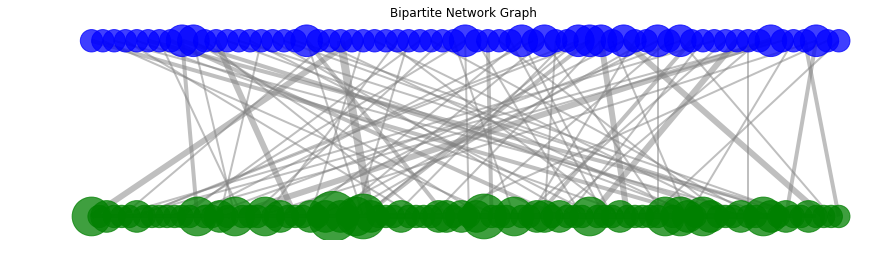

In [5]:
plt.figure(figsize=(15, 4))
           
# set layout position
pos=nx.bipartite_layout(B,top_nodes, align='horizontal') 

colors=[]
for n in dict(B.degree()).keys():
    if n in dict(B.degree(top_nodes)).keys():
        colors.append('blue')
    else:
        colors.append('green')

# nodes
d = B.degree()
nx.draw_networkx_nodes(B,pos, node_color=colors, node_size=[v*500 for v in dict(d).values()], alpha=0.75)

# edges drawn with widths set to edge weight
nx.draw_networkx_edges(B,pos,alpha=0.5,width=[c*2 for (u, v, c) in B.edges.data('weight')],edge_color='grey',style='solid')

plt.axis('off')
plt.title('Bipartite Network Graph')
plt.show()

## Network Reduction

#### Island Method
The island method is a way to split up a large data set into smaller sections with more activity. These smaller sections can then be analyzed individually. Essentially, the large component is "flooded" and the valleys, or the areas data sets with the least edges, are submerged into water. The water, essentially a threshold on the edge values, thus breaks the large component into smaller pieces, or "islands".

We explored this technique using the island method as described in chapter 4 of our Social Network Analysis text.

In [6]:
## Implementing the Island Method to look for important subgroups. 
def trim_edges(b, weight = 1):
    # Implements a trimming of the graph edges for the Island Analysis
    b2 = nx.Graph()
    for u, v, c in B.edges(data=True):
        if c['weight'] > weight:
            b2.add_edge(u,v, weight=c)
    return b2

## Return list of graphs each corresponding to different thresholds
def island_method(B, iterations=3):
    weights= [c for (u, v, c) in B.edges.data('weight')]
    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of step
    step=int((mx-mn)/iterations)
    return [[threshold, trim_edges(B, threshold)] for threshold in range(mn,mx,step)]

#### Island Output

By calling the `island_method` function below, we trim our edges to exclude singular node connections. Our network is now separated here into 55 nodes on 24 island subgraphs. Upon our second and final iteration, our threshold of 2 indicates that our graph contains 16 influencial nodes on 8 islands. And, there are only 2 connections between each.

In [7]:
cc=list(nx.connected_component_subgraphs(B))[0]
island = island_method(cc, iterations = 2)

#print the threshold level, size of the graph, and number of connected components
for i in island:
    print("Threshold:",i[0], "Size:",len(i[1]), "Connections:", len(list(nx.connected_component_subgraphs(i[1]))))

Threshold: 1 Size: 55 Connections: 24
Threshold: 2 Size: 16 Connections: 8


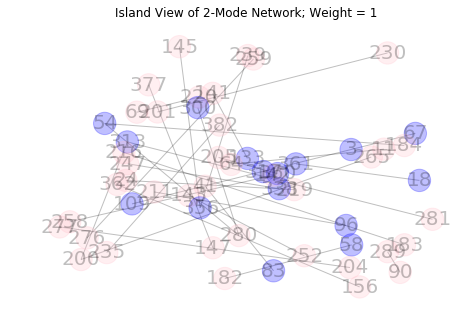

In [8]:
# Apply island method
B1=trim_edges(B,weight=1)

# Set node color based on gender
gender = set(net2m[net2m['gender']=="M"].iloc[:, 0].unique())
nodecolors=[]
for n in dict(B1.degree()).keys():
    if n in gender:
        nodecolors.append('blue')
    else:
        nodecolors.append('pink')

nx.draw_random(B1, node_size=500, alpha=.25, font_size=20, with_labels=True, node_color=nodecolors)

plt.axis('off')
plt.title('Island View of 2-Mode Network; Weight = 1')
plt.show()

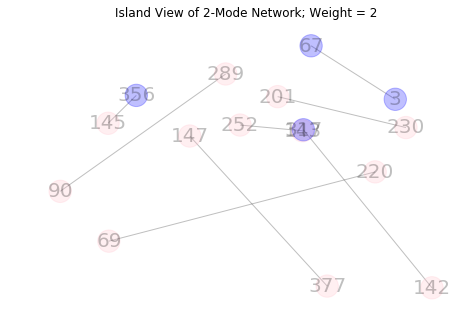

In [9]:
# Apply island method
B2=trim_edges(B,weight=2)

# Set node color based on gender
gender = set(net2m[net2m['gender']=="M"].iloc[:, 0].unique())
nodecolors=[]
for n in dict(B2.degree()).keys():
    if n in gender:
        nodecolors.append('blue')
    else:
        nodecolors.append('pink')

nx.draw_random(B2, node_size=500, alpha=.25, font_size=20, with_labels=True, node_color=nodecolors)

plt.axis('off')
plt.title('Island View of 2-Mode Network; Weight = 2')
plt.show()

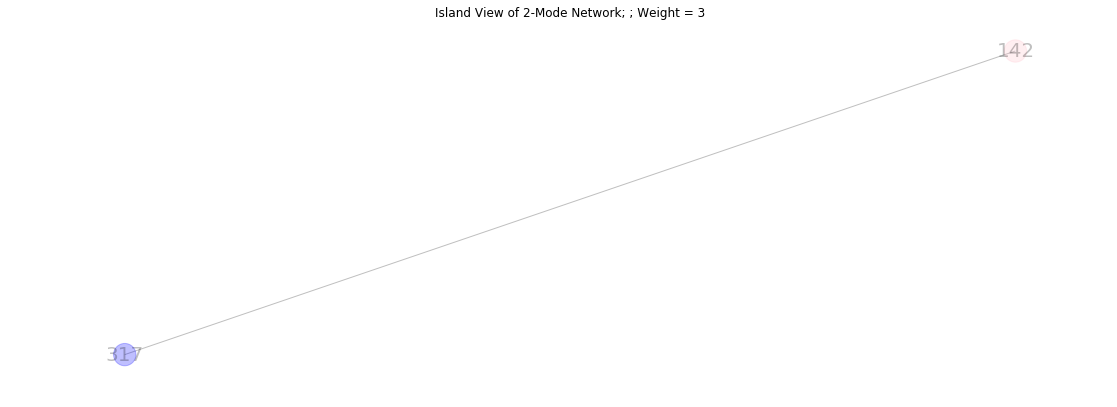

In [10]:
plt.figure(figsize=(15, 5))

B3=trim_edges(B,weight=3)
nodecolors=[]
for n in dict(B3.degree()).keys():
    if n in gender:
        nodecolors.append('blue')
    else:
        nodecolors.append('pink')
nx.draw_random(B3, node_size=500, alpha=.25, font_size=20, with_labels=True, node_color=nodecolors)

plt.axis('off')
plt.title('Island View of 2-Mode Network; ; Weight = 3')
plt.show()

## Analysis 
+ What can you infer about each of the distinct groups?

## Video Presentation

Our recorded submission can be viewed in the embedded video player below: 

In [11]:
%%html

UsageError: %%html is a cell magic, but the cell body is empty.


---
#### References

1. Social Network Analysis for Startups, Maksim Tsvetovat and Alexander Kouznetsov, O'Reilly, Sep 30, 201
2. Seierstad, C., Opsahl, T. (2011). For the few not the many? The effects of affirmative action on presence, prominence, and social capital of female directors in Norway. Scandinavian Journal of Management 27 (1), 44-54, doi: 10.1016/j.scaman.2010.10.002; 
3. NetworkX Bipartite Algorithm. Retrieved from https://networkx.github.io/documentation/stable/reference/algorithms/bipartite.html 